In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from IPython.display import display

<div class="theme"> Overview: Higgs Boson Discovery </div>

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('Higgs_train.csv')
data_test = pd.read_csv('Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

## A Single Model

We start by fitting a basic model we can compare the other models to. We'll pick a decision tree as the base model, because we'll later include random forests and want a fair comparison. We'll tune the decision tree using cross-validation. As usual, we'll be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.

**1.1**: Fit a decision tree model to the training set. Choose a range of tree depths to evaluate. Plot the estimated performance +/- 2 standard deviations for each depth using 5-fold cross validation. Also include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.

*Hint*: use `plt.fill_between` to shade the region.

In [6]:
# your code here
result = []
for max_depth in range(1, 21):
    dt = DecisionTreeClassifier(max_depth=max_depth)
    cv = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5, n_jobs=-1)
    result.append([max_depth, cv.mean(), cv.std()])

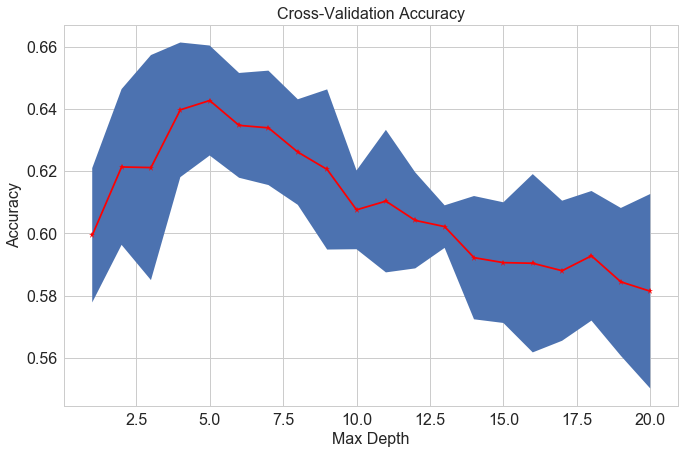

In [7]:
# your code here
result_array = np.array(result)
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(result_array[:,0], result_array[:,1], 'r*-')
ax.fill_between(result_array[:,0], result_array[:,1] - 2*result_array[:,2], result_array[:,1] + 2*result_array[:,2])
ax.tick_params(labelsize=16)
ax.set_title('Cross-Validation Accuracy', fontsize=16)
ax.set_xlabel("Max Depth", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
plt.show()

**1.2** Select an appropriate depth and justify your choice. Using your cross-validation estimates, report the mean +/- 2 stdev. Then report the classification accuracy on the test set. (Store the training and test accuracies in variables to refer to in a later question.)

In [8]:
# your code here
index = result_array.argmax(axis=0)[1]
depth_best = result_array[index, 0]
print("Best depth = {}".format(depth_best))
print("Mean Accuracy = {:.2%}".format(result_array[index, 1]))
print("Mean Accuracy - 2*Std = {:.2%}".format(result_array[index,1] - 2* result_array[index,2]))
print("Mean Accuracy + 2*Std = {:.2%}".format(result_array[index,1] + 2* result_array[index,2]))

Best depth = 5.0
Mean Accuracy = 64.28%
Mean Accuracy - 2*Std = 62.51%
Mean Accuracy + 2*Std = 66.05%


In [9]:
# your code here
dt_single = DecisionTreeClassifier(max_depth=depth_best)
dt_single.fit(X_train, y_train)
dt_single_train_score = dt_single.score(X_train, y_train)
dt_single_test_score = dt_single.score(X_test, y_test)

print("Single Tree on training set = {:.2%}".format(dt_single_train_score))
print("Single Tree on test set = {:.2%}".format(dt_single_test_score))

Single Tree on training set = 68.12%
Single Tree on test set = 64.78%


**Your answer here**

We decided to use 5 as the max depth of the tree because it gives the highest cross validation accuracy with reasonable two standard deviation intervals. 

Although depth 5 has the highest CV score, there isn't enough evidence in the cross validation to distinguish it from depths of 4, 6, or even 7. You could justifiably pick any of these values, reasoning that 4 will give a simpler model that's less likely to overfit, or that the full model will be trained on 20% more data than the CV models and might support a greater depth. We'll pick depth=5.

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? Your answer should refer to the bias-variance trade-off.

The bias-variance dilemma is very signinficant. The bias of a model quantifies how precise a model is across training sets. The variance quantifies how sensitive the model is to small changes in the training set. A robust model is not overly sensitive to small changes. The dilemma involves minimizing both bias and variance; we want a precise and robust model. Simpler models tend to be less accurate but more robust. Complex models tend to be more accurate but less robust.

In Decision trees, limiting the depth will limit the ability of the model to explore the crevaces of the problem and make extremely sharp cuts around the datapoints of the training set for classification. This increases generalizability of the model and prevents overfitting. However, the limitation is clear, it prevents the model from achieving maximum accuracy.

**For students :**

Consider the following example, in face recognition algorithms, such as that on the iPhone X, a too-accurate model would be unable to identity someone who styled their hair differently that day. The reason is that our model may learn irrelevant features in the training data. On the contrary, an insufficiently trained model would not generalize well either. For example, it was recently reported that a face mask could sufficiently fool the iPhone X.

## Bagging

Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

**2.1** Choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth will overfit? Assign your choice to a variable here. (You may want to explore different settings for this value in the problems below.)


In [10]:
# your code here
depth_ovf = 20
dt_single_ovf = DecisionTreeClassifier(max_depth=depth_ovf)
dt_single_ovf.fit(X_train, y_train)

dt_single_ovf_train_score = dt_single_ovf.score(X_train, y_train)
dt_single_ovf_test_score = dt_single_ovf.score(X_test, y_test)

print("Overfitted Depth = {}".format(depth_ovf))
print("Overfitted Single Tree on training set = {:.2%} ".format(dt_single_ovf_train_score))
print("Overfitted Single Tree on test set = {:.2%} ".format(dt_single_ovf_test_score))

Overfitted Depth = 20
Overfitted Single Tree on training set = 100.00% 
Overfitted Single Tree on test set = 59.78% 


We believe depth = 20 will overfit the training set, because the training accuracy is 100%, while the test accuracy is only 60%. Another evidence is that cross-validation accuracy peaks at depth of 5, and then decreases after it, which is a sign of overfitting. Depth of 20 will definitely overfit the model.

**2.2** Create 45 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training (or test) example, each column is one of the trees, and each entry is that tree's prediction for that example. (Labeling the rows and columns is optional.)

Store these results as `bagging_train` and `bagging_test`. Don't worry about visualizing these results yet.

**Structure of `bagging_train` and `bagging_test`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [11]:
# Creating model
np.random.seed(0)
dt_bagging = DecisionTreeClassifier(max_depth=depth_ovf)

# Initializing variables
n_trees = 45
bagging_train = np.zeros((data_train.shape[0], n_trees))
bagging_test = np.zeros((data_test.shape[0], n_trees))
bagging_fn = []

# Conduct bootstraping iterations
for i in range(n_trees):
    X_train_resample, y_train_resample = resample(X_train, y_train, replace=True)
    
    dt_bagging.fit(X_train_resample, y_train_resample)  
    bagging_train[:,i] = dt_bagging.predict(X_train)   
    bagging_test[:,i] = dt_bagging.predict(X_test)
    
    # First node
    bagging_fn.append(dt_bagging.tree_.feature[0])

# Make Predictions Dataframe
columns = ["Bagging-Model_"+str(i+1) for i in range(n_trees)]
bagging_train = pd.DataFrame(bagging_train, columns=columns)
bagging_test = pd.DataFrame(bagging_test, columns=columns)

In [12]:
print(bagging_train.shape)
print(bagging_test.shape)
display(bagging_train.head())
display(bagging_test.head())

(5000, 45)
(5000, 45)


,Bagging-Model_1,Bagging-Model_2,Bagging-Model_3,Bagging-Model_4,Bagging-Model_5,Bagging-Model_6,Bagging-Model_7,Bagging-Model_8,Bagging-Model_9,Bagging-Model_10,Bagging-Model_11,Bagging-Model_12,Bagging-Model_13,Bagging-Model_14,Bagging-Model_15,Bagging-Model_16,Bagging-Model_17,Bagging-Model_18,Bagging-Model_19,Bagging-Model_20,Bagging-Model_21,Bagging-Model_22,Bagging-Model_23,Bagging-Model_24,Bagging-Model_25,Bagging-Model_26,Bagging-Model_27,Bagging-Model_28,Bagging-Model_29,Bagging-Model_30,Bagging-Model_31,Bagging-Model_32,Bagging-Model_33,Bagging-Model_34,Bagging-Model_35,Bagging-Model_36,Bagging-Model_37,Bagging-Model_38,Bagging-Model_39,Bagging-Model_40,Bagging-Model_41,Bagging-Model_42,Bagging-Model_43,Bagging-Model_44,Bagging-Model_45
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


,Bagging-Model_1,Bagging-Model_2,Bagging-Model_3,Bagging-Model_4,Bagging-Model_5,Bagging-Model_6,Bagging-Model_7,Bagging-Model_8,Bagging-Model_9,Bagging-Model_10,Bagging-Model_11,Bagging-Model_12,Bagging-Model_13,Bagging-Model_14,Bagging-Model_15,Bagging-Model_16,Bagging-Model_17,Bagging-Model_18,Bagging-Model_19,Bagging-Model_20,Bagging-Model_21,Bagging-Model_22,Bagging-Model_23,Bagging-Model_24,Bagging-Model_25,Bagging-Model_26,Bagging-Model_27,Bagging-Model_28,Bagging-Model_29,Bagging-Model_30,Bagging-Model_31,Bagging-Model_32,Bagging-Model_33,Bagging-Model_34,Bagging-Model_35,Bagging-Model_36,Bagging-Model_37,Bagging-Model_38,Bagging-Model_39,Bagging-Model_40,Bagging-Model_41,Bagging-Model_42,Bagging-Model_43,Bagging-Model_44,Bagging-Model_45
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


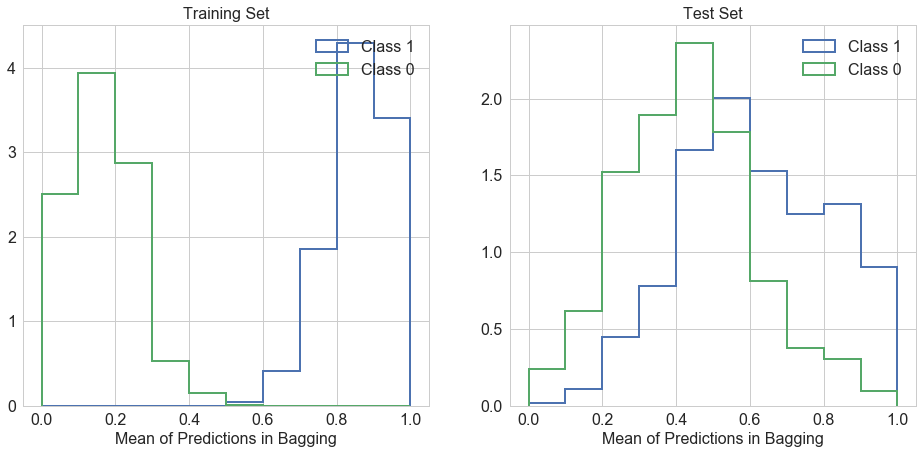

In [13]:
num_to_avg = n_trees 
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for (ax, label, predictions, y) in [
    (axs[0], 'Training Set', bagging_train, y_train), 
    (axs[1], 'Test Set', bagging_test, y_test)
]:
    mean_predictions = predictions.iloc[:,:num_to_avg].mean(axis=1)
    mean_predictions[y == 1].hist(density=True, histtype='step', range=[0,1], label='Class 1', lw=2, ax=ax)
    mean_predictions[y == 0].hist(density=True, histtype='step', range=[0,1], label='Class 0', lw=2, ax=ax)
    ax.legend(loc='best', fontsize=16)
    ax.set_xlabel("Mean of Predictions in Bagging", fontsize=16)
    ax.set_title(label, fontsize=16)
    ax.tick_params(labelsize=16)

**2.3** _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

In [14]:
# Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df, count=-1):
    count = df.shape[1] if count==-1 else count
    temp = df.iloc[:,0:count]
    return np.mean(temp, axis=1)>0.5

bagging_train_score = accuracy_score(y_train, get_prediction(bagging_train, count=-1))
bagging_test_score = accuracy_score(y_test, get_prediction(bagging_test, count=-1))

print("Bagging on training set = {:.2%}".format(bagging_train_score))
print("Bagging on test set = {:.2%}".format(bagging_test_score))

print("Single Tree on training set = {:.2%}".format(dt_single_train_score))
print("Single Tree on test set = {:.2%}".format(dt_single_test_score))

assert bagging_test_score >= dt_single_train_score, "Test set accuracy for bagging is too low."

Bagging on training set = 99.96%
Bagging on test set = 68.22%
Single Tree on training set = 68.12%
Single Tree on test set = 64.78%


**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

In [15]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

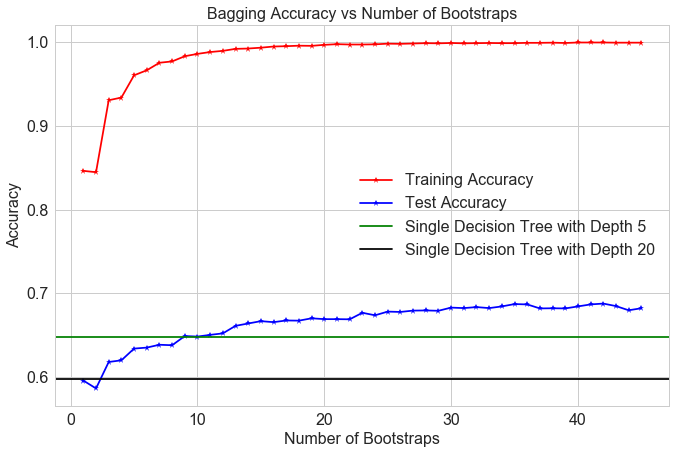

In [16]:
# your code here
train_prediction = running_predictions(bagging_train.iloc[:,:n_trees].values, y_train)
test_prediction = running_predictions(bagging_test.iloc[:,:n_trees].values, y_test)

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(range(1,n_trees+1), train_prediction, 'r*-', label="Training Accuracy")
ax.plot(range(1,n_trees+1), test_prediction, 'b*-', label="Test Accuracy")
ax.axhline(y=dt_single_test_score, color='g', label="Single Decision Tree with Depth 5")
ax.axhline(y=dt_single_ovf_test_score, color='black', label="Single Decision Tree with Depth 20")
ax.legend(loc='best', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title('Bagging Accuracy vs Number of Bootstraps', fontsize=16)
ax.set_xlabel("Number of Bootstraps", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
plt.show()

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single tree with the depth you picked in 2.1. Explain the differences you see.

The Bagging model has less variance and is thus less sensitive to changes in the data. This can be seen by the superior test/validation set performance. Bagging, as a technique, was able to reduce the variance of a Depth-20, highly overfit decision tree model to higher than that of Depth-10 model by using as less as 5 trees, as seen from the graph in 2.4.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

- Both reduce overfitting by reducing variance.
- Limiting tree depth makes model less expressive -> lower performance.
- Bagging averages somewhat-independent estimates.


**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

* Overfitting: Training set may still not be representative. Estimates are still highly correlated, since trees have similar structure.

* Underfitting:  Base learners are only depth-X trees. Still has bias against, e.g., slanted or curved decision boundaries.

## Random Forests 

Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.

**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Evaluate its accuracy on the test set.


In [17]:
# your code here
print("Number of trees = {}".format(n_trees))
print("Depth of the trees = {}".format(depth_ovf))

# Training
dt_rf = RandomForestClassifier(n_estimators=n_trees, max_depth=depth_ovf, n_jobs=-1, random_state=1234)
dt_rf.fit(X_train, y_train)

# Perfromance Evaluation
rf_train_score = accuracy_score(y_train, dt_rf.predict(X_train))
rf_test_score = accuracy_score(y_test, dt_rf.predict(X_test))

print("Random Forest on training set = {:.2%}".format(rf_train_score))
print("Random Forest on test set = {:.2%}".format(rf_test_score))

Number of trees = 45
Depth of the trees = 20
Random Forest on training set = 100.00%
Random Forest on test set = 69.14%


**3.2** For each of the decision trees you fit in the bagging process, how many times is each feature used at the top node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.


In [18]:
# your code here
from collections import Counter

rf_fn = [t.tree_.feature[0] for t in dt_rf.estimators_]

rf_fn_cnt = Counter(rf_fn)
bagging_fn_cnt = Counter(bagging_fn)

print("Random Forest First Node: {}".format(rf_fn_cnt))
print("Bagging First Node: {}".format(bagging_fn_cnt))

Random Forest First Node: Counter({25: 8, 0: 6, 24: 6, 27: 5, 5: 4, 3: 4, 14: 2, 10: 2, 7: 2, 1: 1, 26: 1, 21: 1, 9: 1, 22: 1, 4: 1})
Bagging First Node: Counter({25: 45})


**your answer here**
- Q: For each of the decision trees you fit in the bagging process, how many times is each feature used at the top node? 
- A: The feature number with associated number of times at the top node is listed above. Feature 25 has always been the top node in all bootstrappings, and no other feature has ever been picked. 
<br><br>
- Q: How about for each tree in the random forest you just fit? 
- A: Feature 25 appreas the most frequently with total number of 8 times, followed by feature 0 and 24 with total number of 6 times.
<br><br>
- Q: What about the process of training the Random Forest causes this difference? 
- A: Feature 25 seems to be a very strong predictor, such that bagging algorithm always picks it as the top node. To de-correlate the trees, random forest randomly select a set of predictors from the full set of predictors for each tree at each split. Thus, for some sample of predictors, feature 25 is not among it. Other features that might be correlated to feature 25 will take the leading role and appears as the top node. 
<br><br>
- Q: What implication does this observation have on the accuracy of bagging vs Random Forest?
- A: The major drawback of bagging is that the trees are not independent. Bacause of the strong predictor, the greedy algorithm ensures that most of the models in the ensemble will choose to split on it in early iterations. That is, each tree in the ensemble is identically distributed, with the expected output of the averaged model the same as the expected output of any one of the trees. Random forest is a modified form of bagging that creates ensembles of independent decision trees, so overall the accuracy of random forest should be better or at least similar to the accuracy of bagging. 
<br><br>

**3.3**: Make a table of the training and test accuracy for the following models:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 45 such trees (from Question 2)
- A Random Forest of 45 such trees (from Question 3.1)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

In [19]:
# your code here
print("Single Tree on training set = {:.2%}".format(dt_single_train_score))
print("Single Tree on test set = {:.2%}".format(dt_single_test_score))

print("Overfitted Single Tree on training set = {:.2%} ".format(dt_single_ovf_train_score))
print("Overfitted Single Tree on test set = {:.2%} ".format(dt_single_ovf_test_score))

print("Bagging on training set = {:.2%}".format(bagging_train_score))
print("Bagging on test set = {:.2%}".format(bagging_test_score))

print("Random Forest on training set = {:.2%}".format(rf_train_score))
print("Random Forest on test set = {:.2%}".format(rf_test_score))

Single Tree on training set = 68.12%
Single Tree on test set = 64.78%
Overfitted Single Tree on training set = 100.00% 
Overfitted Single Tree on test set = 59.78% 
Bagging on training set = 99.96%
Bagging on test set = 68.22%
Random Forest on training set = 100.00%
Random Forest on test set = 69.14%


Fill in the following table (ideally in code, but ok to fill in this Markdown cell).


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | 68.12% | 64.80% |
| single depth-X tree | 100.00% | 59.94% |
| bagging 45 depth-X trees | 99.96% | 68.22% |
| Random Forest of 45 depth-X trees | 100.00% | 69.14% |

The single Depth-5 tree underfits the training set: it only gets 68%, while the Depth-20 trees get a perfect (or nearly perfect) score. The single Depth-20 tree overfits badly (perfect performance on train, bad performance on test). However, Bagging 45 such trees gives a better accuracy than the Depth-5 tree: each individual tree is more expressive (lower bias), and averaging many trees' predictions mitigates the increased variance. The Random Forest model performs even slightly better, which is unsurprising since each of the predictions it averages together are less correlated.


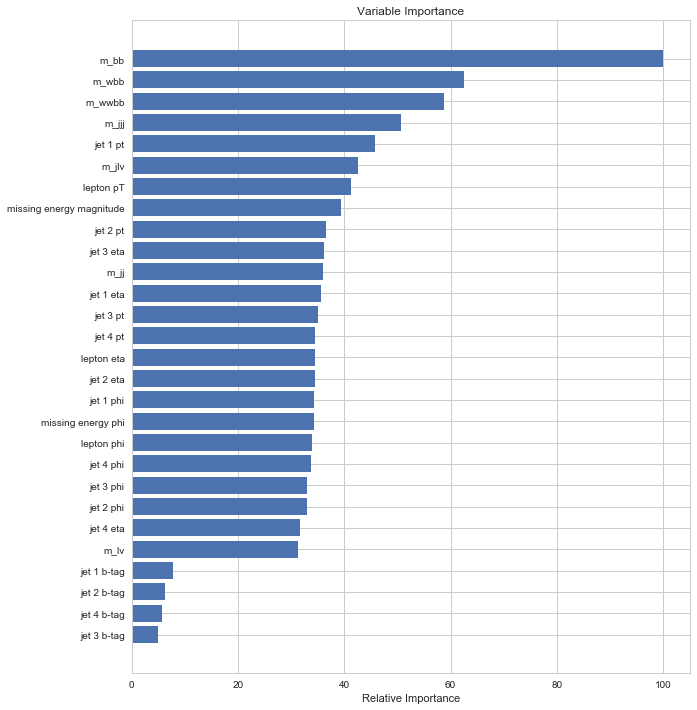

In [20]:
# Random Forest Feature Importance
feature_importance = dt_rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Boosting 

In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more predictors to the ensemble.

**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

In [21]:
# your code here
tree1 = DecisionTreeClassifier(max_depth=3)
tree1.fit(X_train, y_train)
tree1_pred = tree1.predict(X_train)   

print("Tree1 on training set = {:.2%}".format(tree1.score(X_train, y_train)))
print("Tree1 on test set = {:.2%}".format(tree1.score(X_test, y_test)))

Tree1 on training set = 64.18%
Tree1 on test set = 64.42%


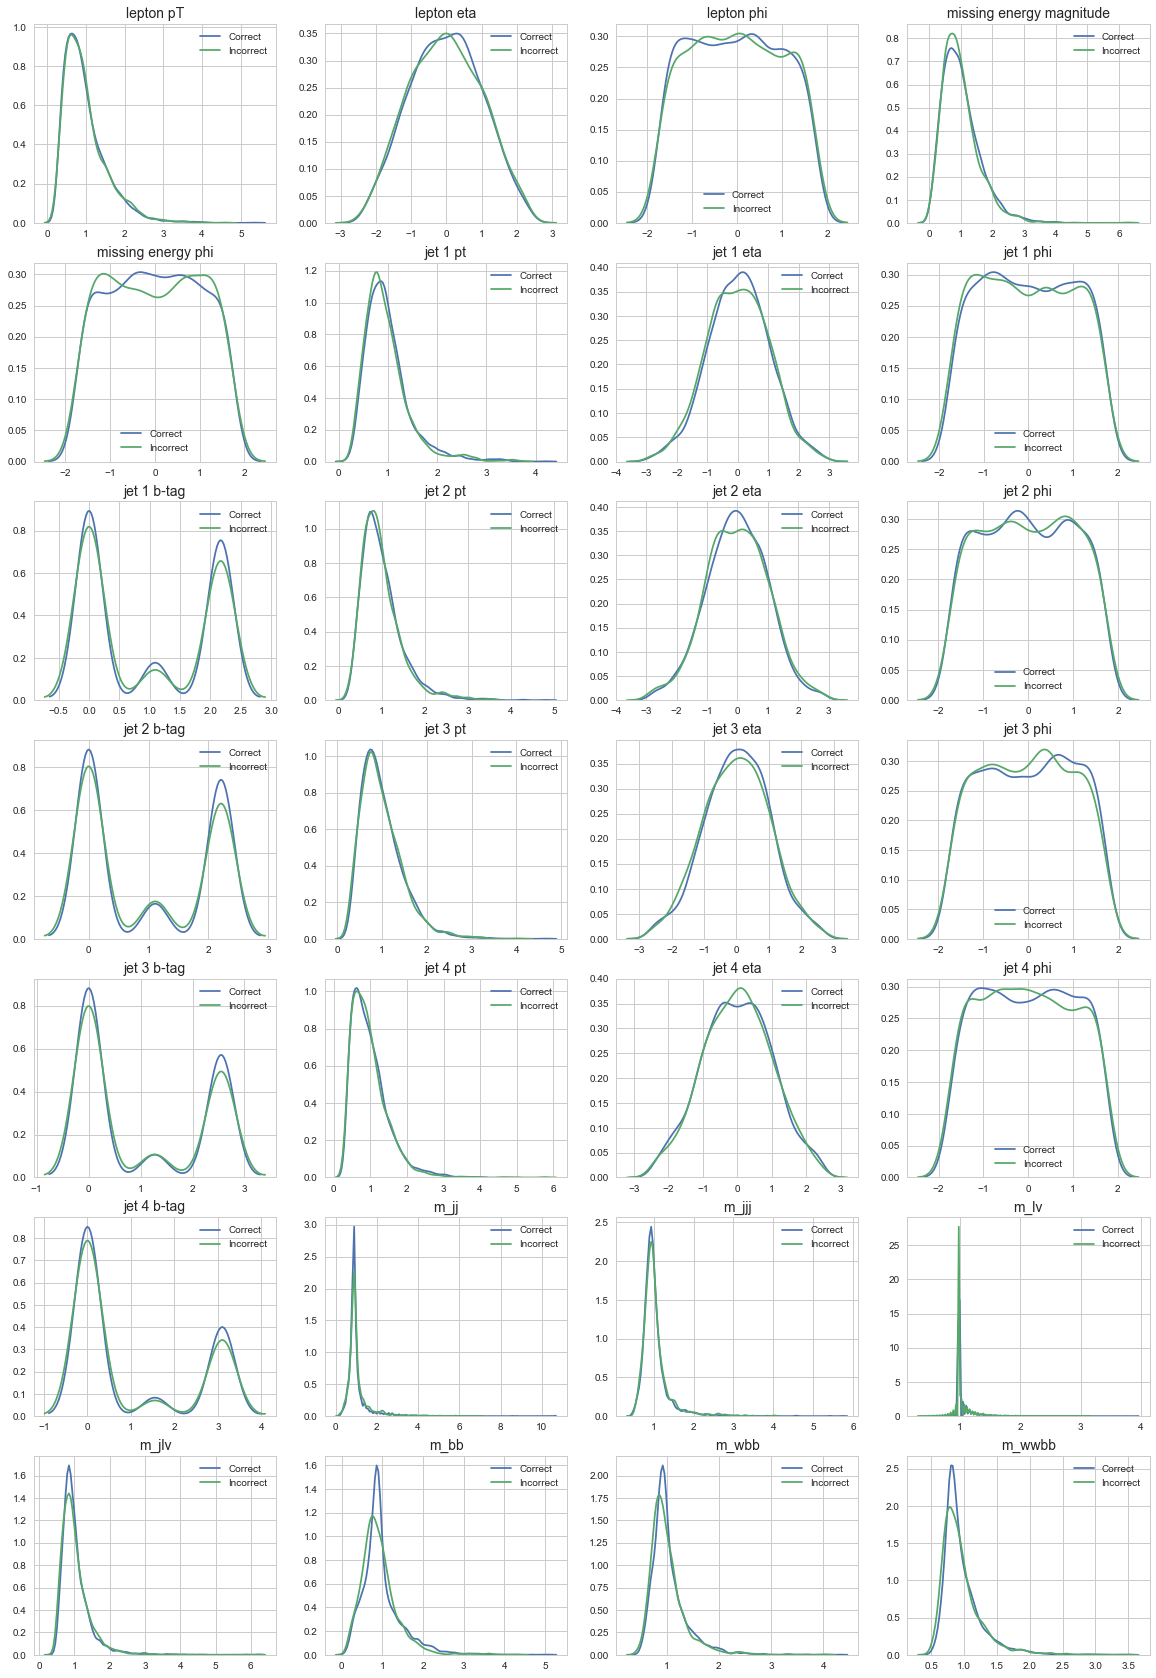

In [22]:
features = data_train.columns[:-1]

f, axs = plt.subplots(7, 4, figsize = (20, 30))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        feature = features[i * len(axs[0]) + j]
        sns.kdeplot(data_train[feature][y_train == tree1_pred], ax=axs[i][j], label='Correct')
        sns.kdeplot(data_train[feature][y_train != tree1_pred], ax=axs[i][j], label='Incorrect')
        axs[i][j].set_title(feature, fontsize=14)

**your answer here**

- Q: Do you notice any predictors for which the distributions are clearly different?
- A: Yes, some of the predictors show very different distributions, like m_bb, m_wbb, m_wwbb.

**4.2** The following code attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.


The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [23]:
# Original Code
def boostmeup():
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X_train, y_train)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
      if tree1.predict([X_train[idx]]) != y_train[idx]:
         sample_weight[idx] = sample_weight[idx] * 2
         q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup()

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


**Your answer here**

If I were a grader for a Data Science class...
- Your code has several stylistic and functionality flaws that I would listed below: 
    - Stylistic flaws: 
        - Watch out for consistent indentation in Python. Python is a language that's style restrict, and indentation is one of the most beautiful part of it, which has saved us countless curly brackets. 
        - Train and test parts have the exact code structure, with only input data difference. Considering about code productivity and usability, you should make the input file as argument passed into the function.
        - Python is a concise and efficient language, so you'd better avoid for loop if not necessary. Build-in list and array operations are computationally faster.
    - Functional flaws: 
        - Make sure that you understand prediction accuracy vs prediction error. Your calculation of prediction accuracy is actually prediction error.
        - In the test part of your code, I guess you meant to write "q = q + 0" on line 47 above, while you wrote it as "q = 0". This explained why your "prediction error" is so low. 
        - In order to calculate prection accuracy on the test set, you need to compare the prediction to the actual response in the test set, while you were comparing to the response in the training set. 

In [25]:
# TF version
def boostmeup(X, y, depth, label, test=False, tree1=None, tree2=None):
    tree = DecisionTreeClassifier(max_depth=depth)
    
    # Tree 1
    if test is False: 
        tree1 = tree.fit(X, y)
    tree1_pred = tree1.predict(X) == y    
    tree1_sw = [1 if x == True else 2 for x in tree1_pred]
    print("tree1 accuracy on {} set = {:.2%}".format(label, tree1_sw.count(1) / len(X)))
    
    # Tree 2
    if test is False: 
        tree2 = tree.fit(X, y, sample_weight=tree1_sw)
    
    t1p = np.array(tree1.predict_proba(X))[:,1]
    t2p = np.array(tree2.predict_proba(X))[:,1]
    tp = (t1p + t2p) / 2
    tree2_pred = [1 if x > 0.5 else 0 for x in tp] == y
    tree2_sw = [1 if x == True else 2 for x in tree2_pred]
    print("tree2 accuracy on {} set = {:.2%}".format(label, tree2_sw.count(1) / len(X)))
    
    return tree1, tree2

tree1, tree2 = boostmeup(X=X_train, y=y_train, depth=3, label="training")
boostmeup(X=X_test, y=y_test, depth=3, label="test", test=True, tree1=tree1, tree2=tree2)

tree1 accuracy on training set = 64.18%
tree2 accuracy on training set = 61.34%
tree1 accuracy on test set = 60.88%
tree2 accuracy on test set = 60.88%


(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'))

My simplified boosting accuracy on training set is actually lower than the single tree accuray, and I think that's because  this simplified boosting doesn't implement several aspects of the full Adaboost that ensure that at least training accuracy doesn't decrease. Testing accuracies are the same. 

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.


In [26]:
# your code here
# Training
dt_ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=800, learning_rate=0.05)
dt_ab.fit(X_train, y_train)

# Perfromance Evaluation
dt_ab_train_score = accuracy_score(y_train, dt_ab.predict(X_train))
dt_ab_test_score = accuracy_score(y_test, dt_ab.predict(X_test))

print("AdaBoost on training set = {:.2%}".format(dt_ab_train_score))
print("AdaBoost on test set = {:.2%}".format(dt_ab_test_score))

AdaBoost on training set = 90.26%
AdaBoost on test set = 66.72%


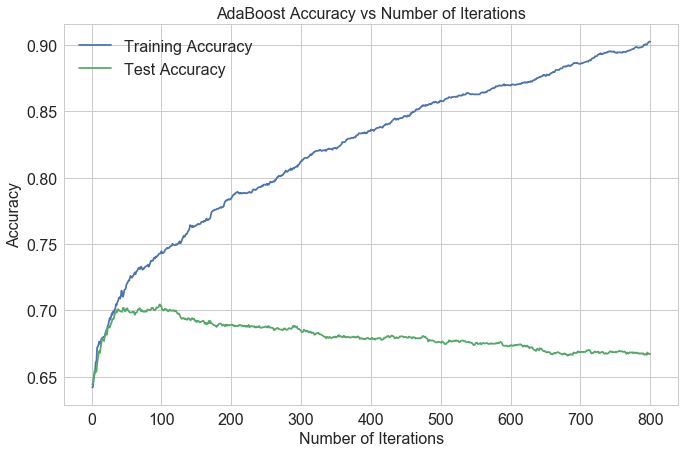

In [27]:
dt_ab_train_scores = list(dt_ab.staged_score(X_train, y_train))
dt_ab_test_scores = list(dt_ab.staged_score(X_test, y_test))

fig, ax = plt.subplots(1, 1, figsize=(11, 7))
ax.plot(range(1, len(dt_ab_train_scores)+1), dt_ab_train_scores, label="Training Accuracy")
ax.plot(range(1, len(dt_ab_test_scores)+1), dt_ab_test_scores, label="Test Accuracy")
ax.legend(loc='best', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title('AdaBoost Accuracy vs Number of Iterations', fontsize=16)
ax.set_xlabel("Number of Iterations", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=16)
plt.show()

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)


In [28]:
# your code here
dt_ab_depths = [1, 2, 3, 4]
dt_ab_train_score_depths = []
dt_ab_test_score_depths = []

for depth in dt_ab_depths: 
    dt_ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=800, learning_rate=0.05)
    dt_ab.fit(X_train, y_train)

    dt_ab_train_score_depths.append(list(dt_ab.staged_score(X_train, y_train)))
    dt_ab_test_score_depths.append(list(dt_ab.staged_score(X_test, y_test)))

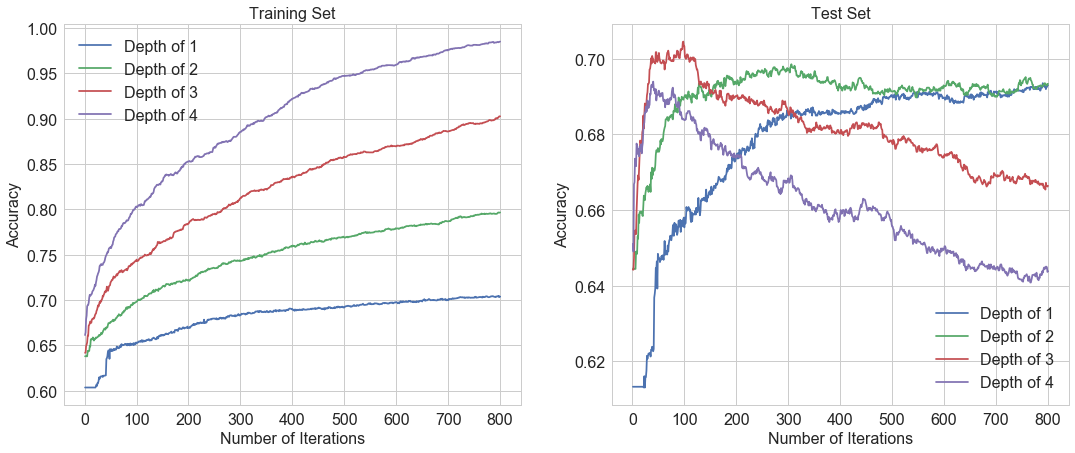

In [29]:
# your code here
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

for depth in dt_ab_depths:    
    ax[0].plot(range(1, len(dt_ab_train_score_depths[depth-1])+1), 
            dt_ab_train_score_depths[depth-1], 
            label="Depth of {}".format(depth))
    
    ax[0].legend(loc='best', fontsize=16)
    ax[0].tick_params(labelsize=16)
    ax[0].set_title('Training Set', fontsize=16)
    ax[0].set_xlabel("Number of Iterations", fontsize=16)
    ax[0].set_ylabel("Accuracy", fontsize=16)

    ax[1].plot(range(1, len(dt_ab_test_score_depths[depth-1])+1), 
            dt_ab_test_score_depths[depth-1], 
            label="Depth of {}".format(depth))
    
    ax[1].legend(loc='best', fontsize=16)
    ax[1].tick_params(labelsize=16)
    ax[1].set_title('Test Set', fontsize=16)
    ax[1].set_xlabel("Number of Iterations", fontsize=16)
    ax[1].set_ylabel("Accuracy", fontsize=16)

plt.show()

**Your answer here**
- Q: What trends do you see in the training and test accuracy?
- A: 
    - Training set: Training accuray monotonically becomes higher with higher number of iterations regardless of depth of the trees. Given same number of iterations, more complex models (higher depth) fit better than the simple models (lower depth) in the training set. 
    - Test set: Model with depth of 1 has monotonical increasing accuracy in test set with higher number of iterations. Model with depths of 2, 3, and 4 first have higher test accuracy, then peaks around at iterations of 300, 100, and 50, after that decreases with with higher number of iterations.

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

In [30]:
# your code here
dt_ab_itr = np.array(dt_ab_test_score_depths[2]).argmax(axis=0) + 1
print("Best Number of iterations for depth of 3 base learner = {}".format(dt_ab_itr))

# Training
dt_ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=dt_ab_itr, learning_rate=0.05)
dt_ab.fit(X_train, y_train)

# Perfromance Evaluation
dt_ab_train_score = accuracy_score(y_train, dt_ab.predict(X_train))
dt_ab_test_score = accuracy_score(y_test, dt_ab.predict(X_test))

print("AdaBoost on training set = {:.2%}".format(dt_ab_train_score))
print("AdaBoost on test set = {:.2%}".format(dt_ab_test_score))

Best Number of iterations for depth of 3 base learner = 98
AdaBoost on training set = 74.28%
AdaBoost on test set = 70.38%



| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | 68.12% | 64.80% |
| single depth-X tree | 100.00% | 59.94% |
| bagging 45 depth-X trees | 99.96% | 68.22% |
| Random Forest of 45 depth-X trees | 100.00% | 69.14% |
| AdaBoost | 74.28% | 70.38% |

Best base learner is the decision tree with depth of 3 and 98 number of iterations, because it gives the best performance in the test set. The AddBoost model with 70.38% accuracy in testing set beats all the previous models we considered.

## Understanding 

This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

- Bagging and Boosting are special cases of Ensembling. 
- In bagging, each model is trained on a fresh bootstrap of the original data: each model is independent. 
- In boosting, each model is trained on a re-weighted copy of the original data where points that are presently being mispredicted get more weight; each model depends on how all of the previous models performed.

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

Comparing the different classifiers on Test Set accuracy, `AdaBoostClassifier` (depth=2, iterations=100) performs best. This seems intuitive because with each model from the beginning we added predictive power (reduced bias) and reduced variance. 

- Simple Decision trees underfit so Bagging included multiple trees.

- Bagging Trees were highly correlated so we created a Random Forest model.

- AdaBoost then used multiple Decision Trees to consecutively fit the residuals left by the previous Decision Tree.

- Finally, by limiting the number of estimators and depth, we were able to find our sweet spot between performance and robustness i.e. the bias-variance tradeoff. 

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

- Having too many trees in Bagging isn't much of an issue since test performance will plateau. 
- In contrast, running Boosting for too long will begin to overfit the data and hurt the overall accuracy.
- Thus, it is worse in Boosting.

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

- Bagging is much better suited to parallelization. 
- In bagging we can train the N models independently, while in boosting we have to wait for the Nth model to finish fitting before we can train the N+1st model.

**5.5** Which of these techniques can be extended to regression tasks? How?

- All of the models/techniques discussed are extensible to Regression tasks. 
- Instead of making splits in Decision Trees based on resultant purity of subsets, we can calculate resultant MSE of subsets.
